<a href="https://colab.research.google.com/github/sajidcsecu/polarImage/blob/main/PolarImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Necessary Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import geometric_transform

# 2. Transforming cartesian image to polar and polar to cartesian

In [3]:
class PolarImageTransformation:
  def car_to_pol_chun(self,image,scaling_factor=4):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2

    # Define output polar image size
    polar_height = int(scaling_factor * height)  # Radial resolution
    polar_width = int(scaling_factor * width)    # Angular resolution
    #polar_image = np.zeros((polar_height, polar_width), dtype=image.dtype)

    # Create grids for radius (r) and angle (theta)
    r = np.linspace(0, 1, polar_height)  # Normalized radius (0 to 1)
    theta = np.linspace(0, 2 * np.pi, polar_width)  # Full 360-degree range

    # Create meshgrid in polar coordinates
    t, r = np.meshgrid(theta, r, indexing='xy')

    print("Radius:")
    print(r)
    print("Theta:")
    print(t)

    # Convert polar coordinates to Cartesian coordinates
    x = (r * (width / 2) * np.cos(t)).astype(np.float32) + center_x
    y = -(r * (height / 2) * np.sin(t)).astype(np.float32) + center_y + 1

    # Clip coordinates to prevent out-of-bounds errors
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map pixel values from Cartesian to Polar coordinates
    # polar_image[:, :] = image[y, x]
    polar_image = cv2.remap(image, x, y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return polar_image

  def pol_to_car_chun(self, polar_image,  scaling_factor=4):

    height, width = polar_image.shape
    cart_height, cart_width = int(height/scaling_factor), int(width/scaling_factor)
    center_x, center_y = cart_width // 2, cart_height // 2

    # Create Cartesian coordinate grids
    y, x = np.meshgrid(np.arange(cart_height), np.arange(cart_width), indexing='ij')


    # Convert Cartesian coordinates to polar coordinates
    r = np.sqrt((x - center_x) ** 2 + (center_y+1-y) ** 2)
    theta = np.arctan2(center_y+1-y, x - center_x)


    # Normalize radius and scale theta
    r = r / (cart_width / 2)  # Normalize radius to range [0,1]
    r = np.clip(r, 0, 1)  # Ensure radius stays within bounds
    theta[theta < 0] += 2 * np.pi  # Convert negative angles to positive
    theta = theta / (2 * np.pi)  # Normalize theta to range [0,1]

    # Convert normalized r, theta to polar image indices
    r_idx = (r * (polar_image.shape[0] - 1)).astype(int)
    theta_idx = (theta * (polar_image.shape[1] - 1)).astype(int)

    # Ensure indices are within valid range
    r_idx = np.clip(r_idx, 0, polar_image.shape[0] - 1)
    theta_idx = np.clip(theta_idx, 0, polar_image.shape[1] - 1)


    # Map pixels from polar to Cartesian
    # cartesian_image = polar_image[r_idx, theta_idx]
    cartesian_image = cv2.remap(polar_image, theta_idx.astype(np.float32), r_idx.astype(np.float32),
                              interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)


    return cartesian_image

  def display_image(self,title,oimage,pimage,rimage):
    # Visualize the original and polar images
    plt.figure(title,figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(oimage, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Polar Coordinate Image")
    plt.imshow(pimage, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("inverse Polar Coordinate Image")
    plt.imshow(rimage, cmap="gray")
    plt.axis("off")
    plt.show()

Resolution of Original Image
(128, 128)
Radius:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00195695 0.00195695 0.00195695 ... 0.00195695 0.00195695 0.00195695]
 [0.00391389 0.00391389 0.00391389 ... 0.00391389 0.00391389 0.00391389]
 ...
 [0.99608611 0.99608611 0.99608611 ... 0.99608611 0.99608611 0.99608611]
 [0.99804305 0.99804305 0.99804305 ... 0.99804305 0.99804305 0.99804305]
 [1.         1.         1.         ... 1.         1.         1.        ]]
Theta:
[[0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 ...
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]]
Resolution of polar Image
(512, 512)
Resolution of recons

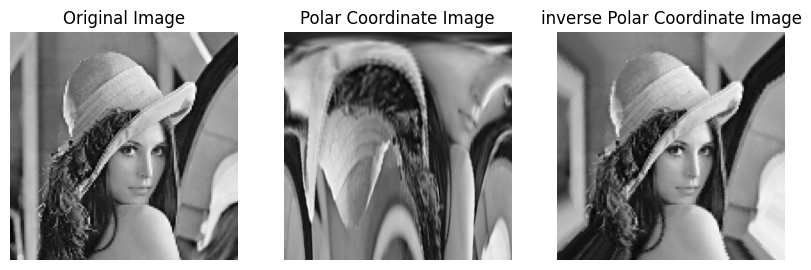

In [4]:
if __name__ == "__main__":
    # Load the image
    # image = cv2.imread("lena/lena.jpg", cv2.IMREAD_GRAYSCALE)
    # #image = cv2.resize(image, (128, 128))
    image = cv2.imread("/content/lena.png", cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))

    # image = np.array([[1, 2, 3, 4, 4 ,5],
    #        [5, 6, 7, 8,3,3],
    #        [9, 10, 11, 12, 9, 8],
    #        [13, 14, 15, 16, 7, 8],
    #        [3, 4, 15, 6, 7, 8],
    #        [9, 10, 11, 12, 9, 8]],dtype=np.uint8)
    pit = PolarImageTransformation()
    print("Resolution of Original Image")
    print(image.shape)
    polar_image = pit.car_to_pol_chun(image)
    print("Resolution of polar Image")
    print(polar_image.shape)
    car_image = pit.pol_to_car_chun(polar_image)
    print("Resolution of reconstructed Image")
    print(car_image.shape)
    pit.display_image("Image", image, polar_image, car_image)

# RHFM Moments

In [5]:
class PolarRHFM:

  def polar_fourier_transform( self, polar_image):
        """
        Computes the Fourier Transform of a polar image.

        Args:
            polar_image (ndarray): Input 2D polar image.

        Returns:
            fft_image (ndarray): Fourier Transform of the polar image.
        """
        fft_image = np.fft.fft2(polar_image)
        fft_image_shifted = np.fft.fftshift(fft_image)
        return fft_image_shifted

  def compute_moments_of_polar_image(self,polar_image, n, m):
        """
        Vectorized computation of moments.

        Args:
            ft_polar_image (ndarray): Fourier-transformed polar image.
            n (ndarray): Array of radial orders.
            m (ndarray): Array of angular frequencies.
            center (int): Center index in the polar image.

        Returns:
            moments (ndarray): Computed moments of shape (len(n), len(m)).
        """
        polar_height, polar_width = polar_image.shape
        r = np.linspace(0, 1, polar_height)
        theta = np.linspace(0, 2 * np.pi, polar_width)
        theta_grid, r_grid = np.meshgrid(theta, r, indexing='xy')

        g_polar_image = np.sqrt(1 / 2) * np.sqrt(r_grid) * polar_image

        ft_polar_image = self.polar_fourier_transform(g_polar_image)

        height, width = ft_polar_image.shape
        center = height // 2
        print("The center : ", center)

        n_grid, m_grid = np.meshgrid(n, m, indexing='ij')

        center_n_plus = center + n_grid
        center_n_minus = center - n_grid
        center_m = center + m_grid

        moments = np.zeros((len(n), len(m)), dtype="complex")

        mask_n_zero = (n_grid == 0)
        moments[mask_n_zero] = np.sqrt(2) * ft_polar_image[center, center_m[mask_n_zero]]

        mask_n_even = (n_grid % 2 == 0) & (n_grid != 0)
        moments[mask_n_even] = ft_polar_image[center_n_plus[mask_n_even], center_m[mask_n_even]] + ft_polar_image[center_n_minus[mask_n_even], center_m[mask_n_even]]

        mask_n_odd = (n_grid % 2 != 0)
        moments[mask_n_odd] = (ft_polar_image[center_n_plus[mask_n_odd], center_m[mask_n_odd]] - ft_polar_image[center_n_minus[mask_n_odd], center_m[mask_n_odd]]) * complex(0, 1)

        self.display_image("G Polar Image", polar_image, g_polar_image, np.log(np.abs(ft_polar_image) + 1e-9)) # added a small value to avoid log(0)

        return moments

  def radial_factors(self, order, r):
        p = np.arange(order + 1)
        p = p[:, np.newaxis, np.newaxis]
        rp = np.ones((order + 1, *r.shape), dtype=r.dtype)
        rp[1::2, ...] = np.sqrt(2) * np.sin(np.pi * (p[1::2, ...] + 1) * r)
        rp[2::2, ...] = np.sqrt(2) * np.cos(np.pi * p[2::2, ...] * r)
        r1 = np.zeros_like(r)
        np.reciprocal(r, where=r != 0., out=r1)
        rp *= np.sqrt(r1)
        return rp

  def exponential_factors(self, repetition, theta):
        q = np.arange(-repetition, repetition + 1)
        q = q[:, np.newaxis, np.newaxis]
        return np.exp(1j * q * theta)

  def basis_function(self, order, repetition, r, t):
        ru = self.radial_factors(order, r)
        ru = ru[:, np.newaxis, ...]
        ev = self.exponential_factors(repetition, t)
        ev = ev[np.newaxis, ...]
        huv = ru * ev
        return huv

  def ct_reconstruct(self,mpq, ihpq):
        mpq = mpq[..., np.newaxis, np.newaxis]
        return np.abs(np.sum(mpq * ihpq, axis=(0, 1)))


  def display_image(self, title, pimage, gimage, ftimage):
        plt.figure(title, figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Polar Image")
        plt.imshow(pimage, cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("G Polar Image")
        plt.imshow(gimage, cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Fourier Transform")
        plt.imshow(ftimage, cmap="gray")
        plt.axis("off")
        plt.show()


Resolution of Original Image
(128, 128)
Radius:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00195695 0.00195695 0.00195695 ... 0.00195695 0.00195695 0.00195695]
 [0.00391389 0.00391389 0.00391389 ... 0.00391389 0.00391389 0.00391389]
 ...
 [0.99608611 0.99608611 0.99608611 ... 0.99608611 0.99608611 0.99608611]
 [0.99804305 0.99804305 0.99804305 ... 0.99804305 0.99804305 0.99804305]
 [1.         1.         1.         ... 1.         1.         1.        ]]
Theta:
[[0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 ...
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]
 [0.         0.01229586 0.02459172 ... 6.25859358 6.27088945 6.28318531]]
Resolution of polar Image
(512, 512)
Order :  [ 0  1  2  

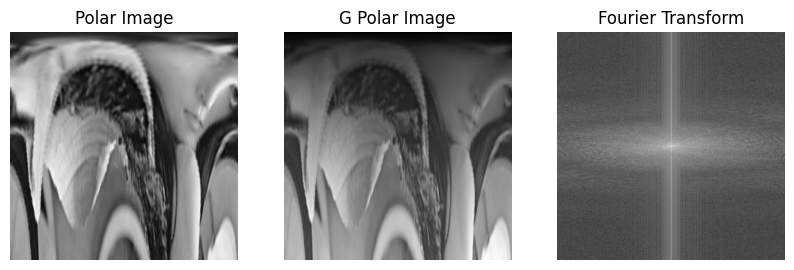

Orthogonal Basis
(11, 21, 512, 512)
Resolution of reconstructed Image
(512, 512)


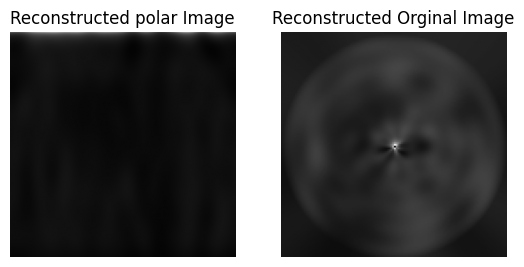

In [9]:
if __name__ == "__main__":
    # Load the image
    # image = cv2.imread("lena/lena.jpg", cv2.IMREAD_GRAYSCALE)
    #image = cv2.resize(image, (128, 128))
    image = cv2.imread("/content/lena.png", cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))

    # image = np.array([[1, 2, 3, 4, 4 ,5],
    #        [5, 6, 7, 8,3,3],
    #        [9, 10, 11, 12, 9, 8],
    #        [13, 14, 15, 16, 7, 8],
    #        [3, 4, 15, 6, 7, 8],
    #        [9, 10, 11, 12, 9, 8]],dtype=np.uint8)

    pit = PolarImageTransformation()
    print("Resolution of Original Image")
    print(image.shape)
    polar_image = pit.car_to_pol_chun(image)
    print("Resolution of polar Image")
    print(polar_image.shape)
    order = 10
    repetition = 10
    n = np.arange(order + 1)
    print("Order : ",n)
    m = np.arange(-repetition, repetition + 1)
    print("Repetition")
    print(m)
    prhfm = PolarRHFM()
    Mpq = prhfm.compute_moments_of_polar_image(polar_image,n,m)
    # print("Moments : ")
    # print(Mpq)
    height, width = polar_image.shape
    r= np.linspace(0, 1, height)  # Normalized radius (0 to 1)
    t = np.linspace(0, 2 * np.pi, width)  # Full 360-degree range
    theta, radius = np.meshgrid(t, r, indexing='xy')
    ihpq = prhfm.basis_function(order, repetition, radius, theta)
    print("Orthogonal Basis")
    print(ihpq.shape)
    reconstructed_polar_image = prhfm.ct_reconstruct(Mpq, ihpq)
    print("Resolution of reconstructed Image")
    print(reconstructed_polar_image.shape)
    plt.subplot(1, 2, 1)
    plt.title("Reconstructed polar Image")
    plt.imshow(reconstructed_polar_image, cmap="gray")
    plt.axis("off")
    car_image = pit.pol_to_car_chun(reconstructed_polar_image)
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Orginal Image")
    plt.imshow(car_image, cmap="gray")
    plt.axis("off")
    plt.show()